# Mars: sky brightness observations from the surface

In this example, we show how archNEMESIS can be used to simulate the measured radiance in observations made from the surface of a planet, specifically Mars. This is relevant for simulations of the future measurements from the Enfys and PanCam instruments on the ExoMars Rosalind Franklin Rover.

Here, we show an example of the diffuse and direct spectral radiance across the sky at a given wavelength. However, this example can be expanded to compute the spectrum at different angles.

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.ticker import ScalarFormatter, MaxNLocator

## 1. Reading the input files

First of all, we are going to read the example input file and examine its contents, aiming to understand how the geometry must be specified to simulation an upward-looking observation.

In [2]:
runname = 'mars'

Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval,Telluric = ans.read_input_files_hdf5(runname)

INFO :: read_apr :: Variables_0.py-823 :: 
Variables_0 :: read_apr :: varident [-1  0  2]. Constructed model "Model2" (id=2)
INFO :: read_apr :: Variables_0.py-826 ::   Model2:
  |- id : 2
  |- parent classes: PreRTModelBase
  |- description: In this model, the atmospheric parameters are scaled using a
  |               single factor with  respect to the vertical profiles in the
  |               reference atmosphere
  |- n_state_vector_entries : 1
  |- state_vector_slice : slice(0, 1, None)
  |- state_vector_start : 0
  |- target : 2
  |- Parameters:
  |  |- scaling_factor :
  |  |  |- slice : slice(0, 1, None)
  |  |  |- unit : PROFILE_TYPE
  |  |  |- description: Scaling factor applied to the reference profile
  |  |  |- apriori value : 1.0


### Atmosphere

The reference atmosphere in this file has been made by extracting profiles from the Mars Climate Database at the ExoMars Rosalind Frankling Rover landing site (Oxia Planum - 18.275°N 335.368°E). The dust profile is normalised so that the column optical depth is 1 at 0.67 $\mu$m.  

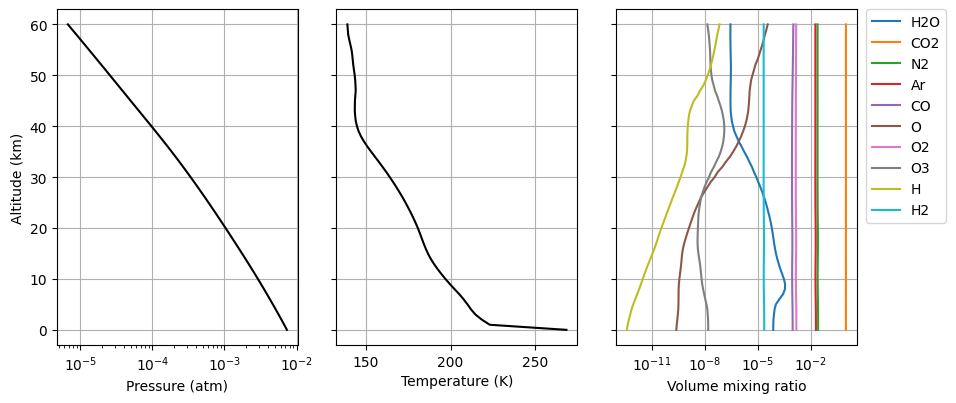

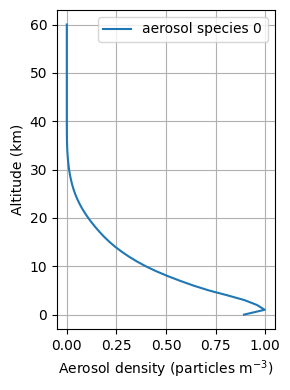

In [3]:
Atmosphere.plot_Atm()
Atmosphere.plot_Dust()

### Optical properties of dust

The optical properties of the Martian dust are taken from [Connour et al. (2022)](https://doi.org/10.1016/j.icarus.2022.115177), but choosing a dust population with $r_{\mathrm{eff}}$ = 1.5 $\mu$m. The optical properties are normalised so that $k_{\mathrm{eff}}$ = 1 at 0.67$\mu$m.

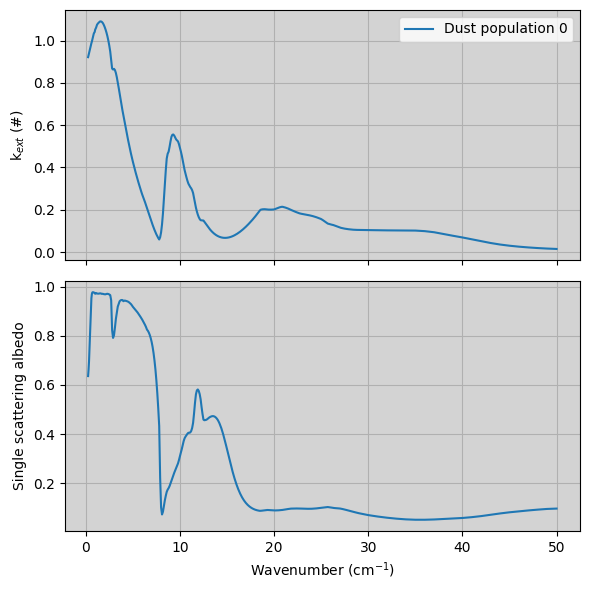

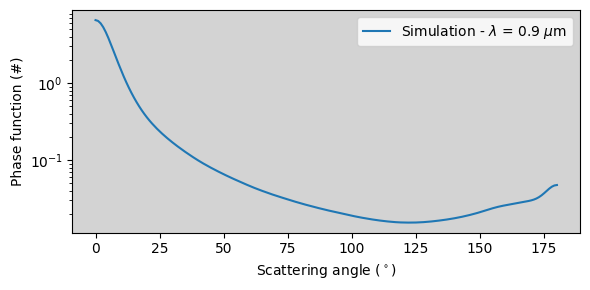

In [4]:
#Plotting the extinction coefficient and single scattering albedo
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True)

for i in range(Scatter.NDUST):

    ax1.plot(Scatter.WAVE,Scatter.KEXT[:,i],label='Dust population '+str(i))
    ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,i])

ax1.legend()
ax1.grid()
ax2.grid()
ax2.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('k$_{ext}$ (#)')
ax2.set_ylabel('Single scattering albedo')
ax1.set_facecolor("lightgray")
ax2.set_facecolor("lightgray")
plt.tight_layout()


#Plotting the scattering phase function
theta = np.linspace(0.,180.,181)
phase_meas = Scatter.calc_phase(theta,Measurement.VCONV[:,0])

fig,ax1 = plt.subplots(1,1,figsize=(6,3))
ax1.plot(theta,phase_meas[0,:,0],label=f"Simulation - $\lambda$ = {Measurement.VCONV[0,0]} $\mu$m")
ax1.legend()
ax1.set_yscale("log")
ax1.set_ylabel('Phase function (#)')
ax1.set_xlabel('Scattering angle ($^\circ$)')
ax1.set_facecolor("lightgray")
plt.tight_layout()

### Scattering field

The multiple scattering calculations require discretising the atmosphere into a finite number of ordinates in the polar direction (i.e., zenith ordinates), while the azimuth space is described through a Fourier decomposition, where we need to specify the number of Fourier components. These parameters are specified in the Scatter class.

Here, we include some default values, but this can vary depending on the characteristics of the phase function and the degree of scattering in the atmosphere.

In [5]:
print("Default values ")
print("****************************************************************************************************")
print("Number of Fourier components = ",Scatter.NF)
print('Number of zenith ordinates = ',Scatter.NMU)
print('Zenith ordinates = ',np.arccos(Scatter.MU)/np.pi*180.,"degrees")
print("")
print("")

print("User-defined values ")
print("****************************************************************************************************")

Scatter.NF = 30
Scatter.NMU = 10
Scatter.calc_GAUSS_LOBATTO()

print("Number of Fourier components = ",Scatter.NF)
print('Number of zenith ordinates = ',Scatter.NMU)
print('Zenith ordinates = ',np.arccos(Scatter.MU)/np.pi*180.,"degrees")

Default values 
****************************************************************************************************
Number of Fourier components =  10
Number of zenith ordinates =  5
Zenith ordinates =  [80.48655994 61.45003531 42.37292783 23.14196267  0.        ] degrees


User-defined values 
****************************************************************************************************
Number of Fourier components =  30
Number of zenith ordinates =  10
Zenith ordinates =  [85.38005309 76.1399168  66.89899917 57.65657253 48.41147735 39.16156768
 29.90215744 20.62035207 11.26220371  0.        ] degrees


### Measurement

In the Measurement class, apart from the spectral range of the simulation, we need to define the geometry of the observation. In this case, the spectral range of the simulation is rather arbitrary, and we have selected a few wavelengths around 0.9 $\mu$m. Regarding the geometry, we need to define it using the EMISS_ANG, SOL_ANG and AZI_ANG angles.

Since we want to simulate the radiance in any direction, we need to set as many measurements as needed, all with their unique viewing azimuth and emission angle pairs. In particular, the number of geometries will be $N_{AZI} \times N_{EMI}$.  

Regarding the emission angle, upward-looking observations are defined by setting $e>90^\circ$. Specifically, an emission angle of $e$ = 180$^\circ$ indicates looking straight up to the zenith, while $e$ = 90$^\circ$ indicates looking towards the horizon. However, since the multiple scattering code assumes a plane parallel atmosphere, the limit of $e$ = 90$^\circ$ should never be approached. Indeed, we should restrict the angles to be encompassed by the zenith ordinates. In this particular case, where we have selected NMU = 10, the emission angle should be $\sim$95$^\circ$ > $e$ $\geq$ 180$^\circ$.

Regarding the azimuth direction, we select angles from 0 to 180, so that we can reconstruct the sky brightness in any direction.

In the case of the solar zenith angle, this will be the same for all geometries. For our simulation, it is better to select the solar zenith angle coincident to one of the zenith ordinates, so that the solar flux does not need to be interpolated between two ordinates. 

In [9]:
#Setting solar zenith angle to one of the zenith ordinates in our scattering setup
#Measurement.SOL_ANG[:,:] = 48.41147735
Measurement.SOL_ANG[:,:] = 76.1399168
print("Solar zenith angle = ",np.unique(Measurement.SOL_ANG[:,:]),"degrees")

#Printing the values of the emission angles chosen in our simulation
print("Emission angles selected = ",np.unique(Measurement.EMISS_ANG),"degrees")

#Printing the values of the emission angles chosen in our simulation
print("Azimuth angles selected = ",np.unique(Measurement.AZI_ANG),"degrees")

Solar zenith angle =  [76.1399168] degrees
Emission angles selected =  [ 95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145. 150. 155. 160.
 165. 170. 175. 180.] degrees
Azimuth angles selected =  [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180.] degrees


## 2. Running forward model

Running multiple scattering calculations is often time consuming, but the code internally solves the radiation field in any direction, so calculating the radiance at all directions can take similar than calculating it at a single direction. This is optimisation is exploited when using the nemesisC version of the forward model, which we use here.

Another thing to note is that the forward model will compute all scattering, absorption, and emission processes. Therefore, if we want to differentiate between the direct solar and diffuse components, we need to run two simulations, one with the complete setup, and one turning off the scattering of light.

In [10]:
#Complete simulation
ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV = ForwardModel.nemesisCfm()

#Non-scattering clouds
ScatterX = deepcopy(Scatter)
ScatterX.SGLALB[:,:] = 0.0
ScatterX.KSCA[:,:] = 0.0
ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=ScatterX,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV_DIRECT = ForwardModel.nemesisCfm()

SPECONV_DIFFUSE = SPECONV - SPECONV_DIRECT

INFO :: calc_path_C :: ForwardModel_0.py-3548 :: calc_path_C :: All geometries are upward-looking.
INFO :: calculate_vertical_cia_opacity :: ForwardModel_0.py-3780 :: self.CIAX not included in calculations
INFO :: calculate_layer_opacity :: ForwardModel_0.py-3851 :: CIRSrad :: Aerosol optical depths at  (np.float64(0.9), ' :: ', array([1.05099212]))
INFO :: calculate_layer_opacity :: ForwardModel_0.py-3869 :: Calculating TOTAL opacity
INFO :: calculate_layer_opacity :: ForwardModel_0.py-3886 :: CIRSradg :: Calculating TOTAL line-of-sight opacity
INFO :: CIRSrad :: ForwardModel_0.py-4218 :: CIRSrad :: IMODM = <PathCalc.MULTIPLE_SCATTERING|PLANCK_FUNCTION_AT_BIN_CENTRE: 8448>
INFO :: calculate_multiple_scattering_spectrum :: ForwardModel_0.py-4111 :: CIRSrad :: Performing multiple scattering calculation
INFO :: calculate_multiple_scattering_spectrum :: ForwardModel_0.py-4112 :: CIRSrad :: NF =  (30, '; NMU = ', 10, '; NPHI = ', np.int32(101))
INFO :: nemesisCfm :: ForwardModel_0.py-1530 

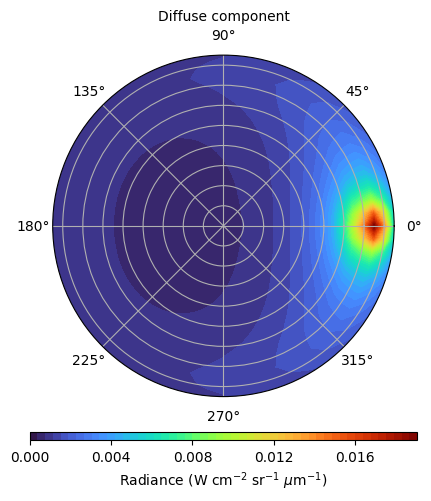

In [11]:
#Re-shaping arrays
#########################################################

#Changing the shape of the arrays so that we end up with a 2D array for (theta,phi)

theta = np.sort(np.unique(Measurement.EMISS_ANG))
phi = np.sort(np.unique(Measurement.AZI_ANG))

NMU = len(theta)
NPHI = len(phi)
DIFFUSE = np.zeros((Measurement.NCONV[0],NMU,NPHI))
for i in range(len(theta)):
    for j in range(len(phi)):
    
        isel = np.where( (Measurement.EMISS_ANG[:,0]==theta[i]) & (Measurement.AZI_ANG[:,0]==phi[j]))[0][0]
        DIFFUSE[:,i,j] = SPECONV_DIFFUSE[:,isel]

vmin = 0.
vmax = SPECONV_DIFFUSE[0,:].max()

cmap = 'turbo'

nlevels = 51
levels = np.linspace(vmin, vmax, nlevels)

#Version 1
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2, 1, height_ratios=[40, 1])  # Adjust width_ratios as needed
axx = fig.add_subplot(gs[0,0],polar=True)
cax = fig.add_subplot(gs[1,0])
im = axx.contourf(phi/180.*np.pi, 180.-theta, DIFFUSE[0,:,:],levels=levels,cmap=cmap,vmin=vmin,vmax=vmax)
im = axx.contourf(-phi/180.*np.pi, 180.-theta,  DIFFUSE[0,:,:],levels=levels,cmap=cmap,vmin=vmin,vmax=vmax)
axx.set_title('Diffuse component',fontsize=10)
axx.set_yticklabels([])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Radiance (W cm$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)')  # Replace with your label
#cbar.locator = MaxNLocator(nticks)

#Replace the FixedLocator imposed by contourf
cbar.locator = MaxNLocator(nbins=5)

